## Study feasiblity of analyzing large spatial deformations on the Mirrors

**In the large-spatial error analysis, zernike polynomals with maximum order of 4th are used to describe the mirror deformations.**

In [2]:
import sys,os
sys.path.append('..')
from ccat_holo.Pyccat import CCAT_holo
import time
import torch as T
import numpy as np
import h5py

from ccat_holo.fitting_error_plot import Fit_M_Surface,Fit_M_Surface_zk,colormap
from ccat_holo.pyplot import plot_beamcontour
from ccat_holo.zernike_torch import N as poly_N

z_order=4

In [3]:
# 1. Model folder
Model_folder='../CCAT_model'
# 2. Configuration of the Holography system
holo_setup={'Rx1':([0,0,600],'../scan/51/on-axis.txt'), 
            'Rx2':([400,400,600],'../scan/51/400_400_600.txt'),
            'Rx3':([400,-400,600],'../scan/51/400_-400_600.txt'),
            'Rx4':([-400,400,600],'../scan/51/-400_400_600.txt'),
            'Rx5':([-400,-400,600],'../scan/51/-400_-400_600.txt')
            }
# Define 5 receiver positions in the 'Coord_Rx' system, e.g [+/-400,+/-400,600]
# and their field points that are stored in file 'scan/400_400_600.txt'. The field
# points of the measured beam maps are from the read out of the telescope coders.
#####################
# 3. Output_folder is the folder used to store the intermediate data of the first
#    beam calculation and the analysing results.
Output_folder='Analysis1'

# 4. Create the FYST holography Model and check the telescope model and 
# holographic setup in the 3D view.
Model=CCAT_holo(Model_folder,Output_folder,holo_conf=holo_setup)

FYST telescope model has been created!!


In [4]:
# 5. Running the time-consuming first beam calculation.
# Model.First_Beam_cal()

# 6. Make the farward beam calculation function, (Model.FF)
Model.mk_FF(fitting_param='zernike',Device=T.device('cpu'),Z_order=z_order)

**1. Surface diagnosis for the 'twist-only' errors on M2**

In [5]:
# 7. load the meausred beams
'''Meaused data'''
Meas_beam=np.genfromtxt('Meas_beams2/GRASP_296GHz_51_51_Large_deformations_0.txt',delimiter=',')
Meas_beam=T.tensor(Meas_beam)

In [ ]:
# 8. Find the large-scale parameters. The fitting results are stored in file 'fit_LP.h5py'
Model.fit_LP(Meas_beam,Device=T.device('cpu'),outputfilename='fit_LP_zk_0',Init=np.zeros((2,poly_N(z_order))))

In [6]:
# Load the results from h5py file
with h5py.File(Output_folder+'/fit_LP_zk_0.h5py','r') as f:
    fit_LP=f['x'][:]

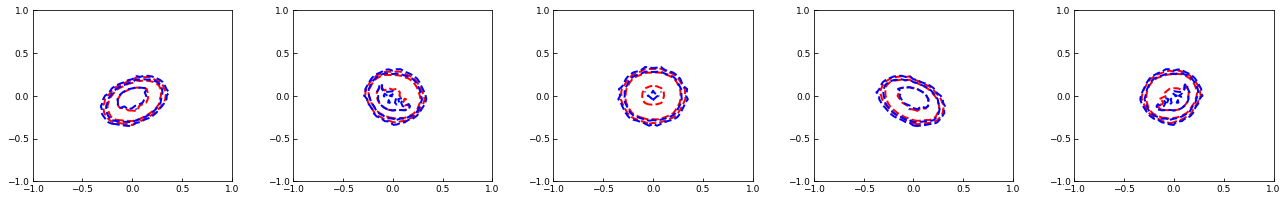

In [7]:
Beams_LP=Model.FF(T.zeros((2,poly_N(z_order))),
                  fit_LP[0:5*6],
                  fit_LP[5*6:]).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_LP,Beams_ref,
                 levels=[-35,-30,-20,-15])

In [ ]:
# 9. analysis the surface errors
Model.fit_surface_zk(Meas_beam,
                  constraint=[0.01,0.01],
                  Device=T.device('cpu'),
                  Init_LP=fit_LP,
                  outputfilename='fit_adjusters_zernike_0')

In [8]:
# Load the results from h5py file
with h5py.File(Output_folder+'/fit_adjusters_zernike_0.h5py','r') as f:
    fit_zk=f['x'][:]

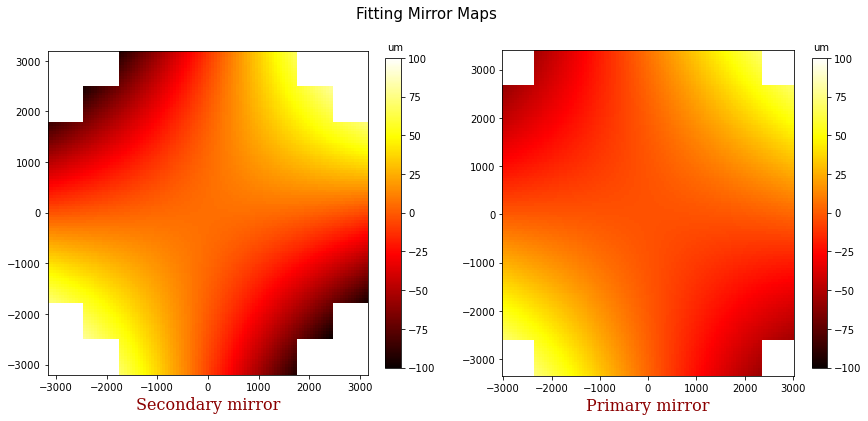

In [10]:
Fit_M_Surface_zk(fit_zk[0:-5*11],z_order,model_file='../CCAT_model',vmax=100,vmin=-100)

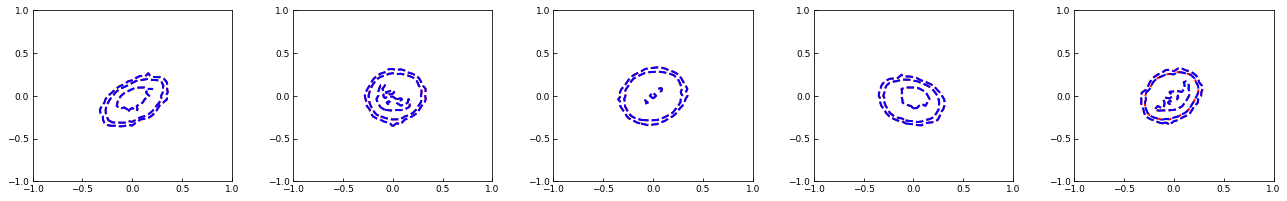

In [11]:
Beams_zk=Model.FF(T.cat((T.zeros((2,3)),T.tensor(fit_zk[0:-5*11]).reshape(2,-1)),axis=1),
                  T.tensor(fit_zk[-5*11:-5*5]),
                  T.tensor(fit_zk[-5*5:])).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_zk,Meas_beam,
                 levels=[-35,-30,-20,-15])


**2. Surface diagnosis for the case of 'twist-only' errors on M2, Rx position errors and 30um panel random deforamtions**

In [16]:
# 7. fit systematic alignment errors (Large-scale parameters):
'''Meaused data'''
Meas_beam=np.genfromtxt('Meas_beams2/GRASP_296GHz_51_51_Large_deformations.txt',delimiter=',')
Meas_beam=T.tensor(Meas_beam)

In [17]:
# 8. Find the large-scale parameters. The fitting results are stored in file 'fit_LP.h5py'
outputname='fit_LP_zk_ad'
#Model.fit_LP(Meas_beam,Device=T.device('cpu'),outputfilename=outputname,Init=np.zeros((2,poly_N(z_order))))
# Load the results from h5py file
with h5py.File(Output_folder+'/'+outputname+'.h5py','r') as f:
    fit_LP=f['x'][:]


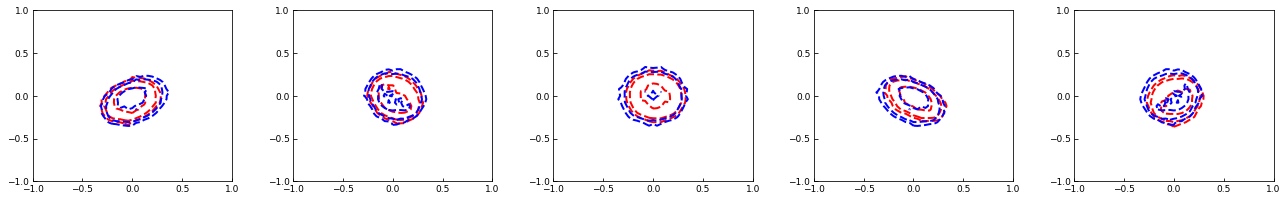

In [18]:
# plot beam for the large-scale alignment errors
Beams_LP=Model.FF(T.zeros((2,poly_N(z_order))),
                  fit_LP[0:5*6],
                  fit_LP[5*6:]).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_LP,Beams_ref,
                 levels=[-35,-30,-20,-15])

In [ ]:
outputname='fit_adjusters_zernike'
Model.fit_surface_zk(Meas_beam,
                  constraint=[0.1,0.1],
                  Device=T.device('cpu'),
                  Init_LP=fit_LP,
                  outputfilename=outputname)

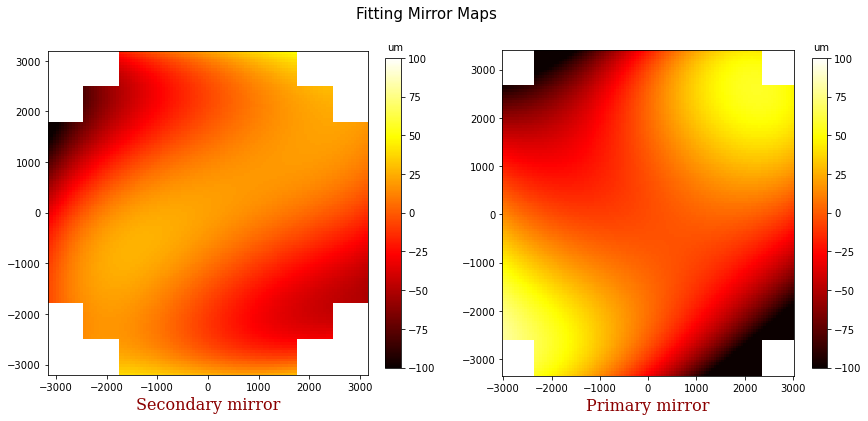

In [20]:
# Load the results from h5py file
with h5py.File(Output_folder+'/'+outputname+'.h5py','r') as f:
    fit_zk=f['x'][:]

Fit_M_Surface_zk(fit_zk[0:-5*11],z_order,model_file='../CCAT_model',vmax=100,vmin=-100)

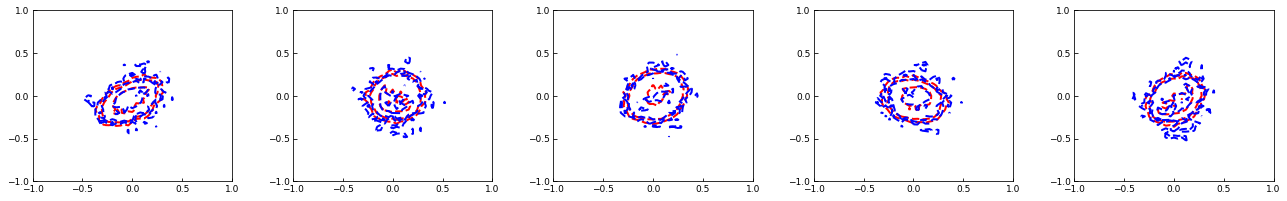

In [21]:
Beams_zk=Model.FF(T.cat((T.zeros((2,3)),T.tensor(fit_zk[0:-5*11]).reshape(2,-1)),axis=1),
                  T.tensor(fit_zk[-5*11:-5*5]),
                  T.tensor(fit_zk[-5*5:])).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_zk,Meas_beam,
                 levels=[-35,-30,-20,-15])

**2.1. Fit the mirror deformations just fitting M2 surface**

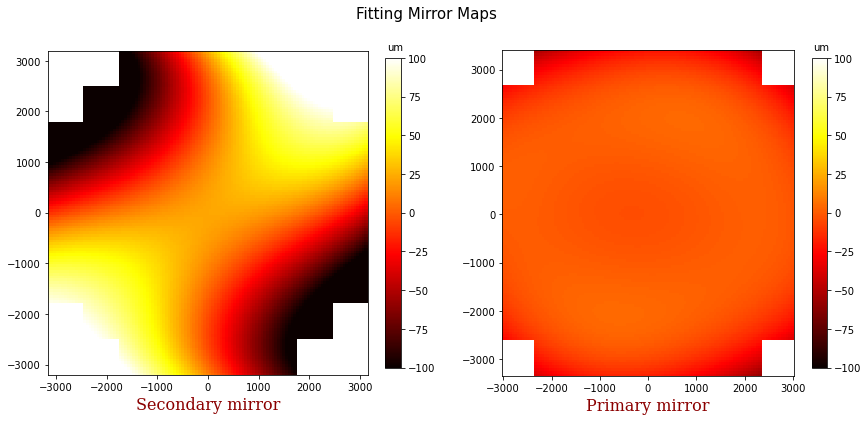

In [27]:
outputname='fit_adjusters_zernike_m2'
Model.fit_surface_zk(Meas_beam,
                  constraint=[0.1,10],
                  Device=T.device('cpu'),
                  Init_LP=fit_LP,
                  outputfilename=outputname)
# Load the results from h5py file
with h5py.File(Output_folder+'/'+outputname+'.h5py','r') as f:
    fit_zk=f['x'][:]

Fit_M_Surface_zk(fit_zk[0:-5*11],z_order,model_file='CCAT_model',vmax=100,vmin=-100)


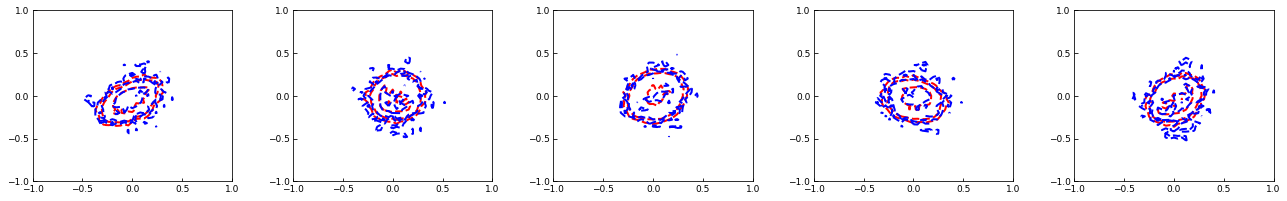

In [28]:
Beams_zk=Model.FF(T.cat((T.zeros((2,3)),T.tensor(fit_zk[0:-5*11]).reshape(2,-1)),axis=1),
                  T.tensor(fit_zk[-5*11:-5*5]),
                  T.tensor(fit_zk[-5*5:])).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_zk,Meas_beam,
                 levels=[-35,-30,-20,-15])

**2.2. Fit the mirror deformations just fitting M1 surface**

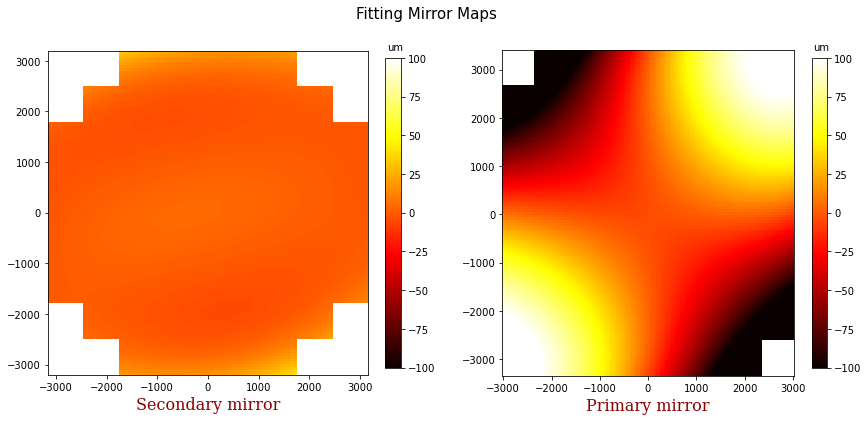

In [25]:
outputname='fit_adjusters_zernike_m1'
Model.fit_surface_zk(Meas_beam,
                  constraint=[10,0.1],
                  Device=T.device('cpu'),
                  Init_LP=fit_LP,
                  outputfilename=outputname)
# Load the results from h5py file
with h5py.File(Output_folder+'/'+outputname+'.h5py','r') as f:
    fit_zk=f['x'][:]

Fit_M_Surface_zk(fit_zk[0:-5*11],z_order,model_file='../CCAT_model',vmax=100,vmin=-100)

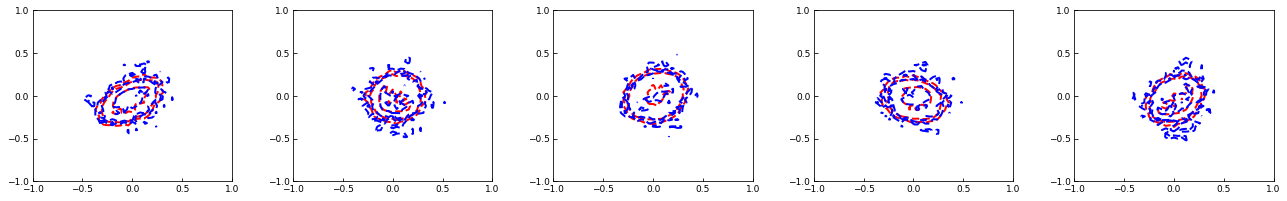

In [26]:
Beams_zk=Model.FF(T.cat((T.zeros((2,3)),T.tensor(fit_zk[0:-5*11]).reshape(2,-1)),axis=1),
                  T.tensor(fit_zk[-5*11:-5*5]),
                  T.tensor(fit_zk[-5*5:])).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_zk,Meas_beam,
                 levels=[-35,-30,-20,-15])

**3. Surface diagnosis for the case of 'twist-only' errors on M2 and M1, Rx position errors and 30um panel random deforamtions**  

The large spatial errors on the 

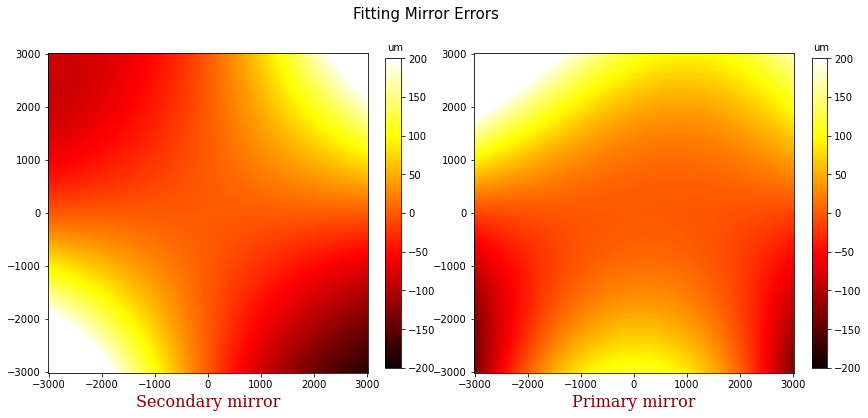

In [46]:
co2=np.array([[0., 0., 0],
             [0., 0.23, -0.05],
             [0, 0., 0.1]])
x0,y0=np.meshgrid(np.linspace(-1,1,201),np.linspace(-1,1,201))
E_m2=np.polynomial.polynomial.polyval2d(x0,y0,co2)
co1=np.array([[0, 0, -0.11400925],
              [0,  0.05859948,  0.05778664],
              [ 0.01346402, -0.20759481,  0.02528261]])
E_m1=np.polynomial.polynomial.polyval2d(x0,y0,co1)
vmax=200
vmin=-vmax
colormap(x0*3000,y0*3000,-E_m1*1000,
         x0*3000,y0*3000,E_m2*1000,
         Vmax=vmax,Vmin=vmin,suptitle='Fitting Mirror Errors')

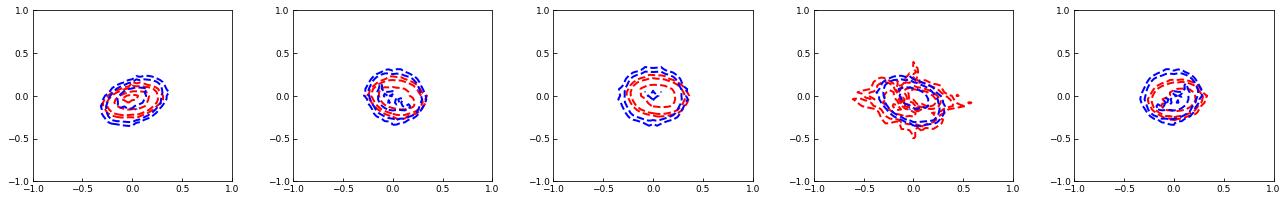

In [29]:
# 7. fit systematic alignment errors (Large-scale parameters):
'''Meaused data'''
Meas_beam=np.genfromtxt('Meas_beams2/GRASP_296GHz_51_51_Large_deformations_m2_m1.txt',delimiter=',')
Meas_beam=T.tensor(Meas_beam)

# 8. Find the large-scale parameters. The fitting results are stored in file 'fit_LP.h5py'
outputname='fit_LP_zk_ad_m1_m2'
Model.fit_LP(Meas_beam,Device=T.device('cpu'),outputfilename=outputname,Init=np.zeros((2,poly_N(z_order))))
# Load the results from h5py file
with h5py.File(Output_folder+'/'+outputname+'.h5py','r') as f:
    fit_LP=f['x'][:]

# plot beam for the large-scale alignment errors
Beams_LP=Model.FF(T.zeros((2,poly_N(z_order))),
                  fit_LP[0:5*6],
                  fit_LP[5*6:]).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_LP,Beams_ref,
                 levels=[-35,-30,-20,-15])

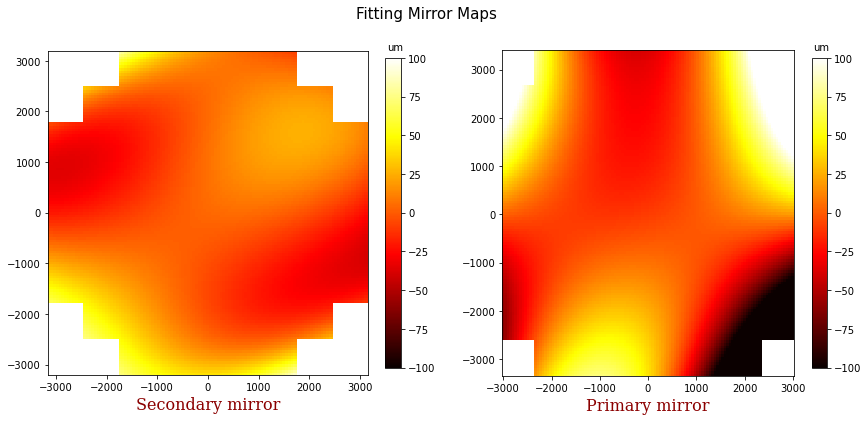

In [31]:
outputname='fit_adjusters_zernike_m1_m2'
Model.fit_surface_zk(Meas_beam,
                  constraint=[0.1,0.1],
                  Device=T.device('cpu'),
                  Init_LP=fit_LP,
                  outputfilename=outputname)
# Load the results from h5py file
with h5py.File(Output_folder+'/'+outputname+'.h5py','r') as f:
    fit_zk=f['x'][:]
Fit_M_Surface_zk(fit_zk[0:-5*11],z_order,model_file='CCAT_model',vmax=100,vmin=-100)

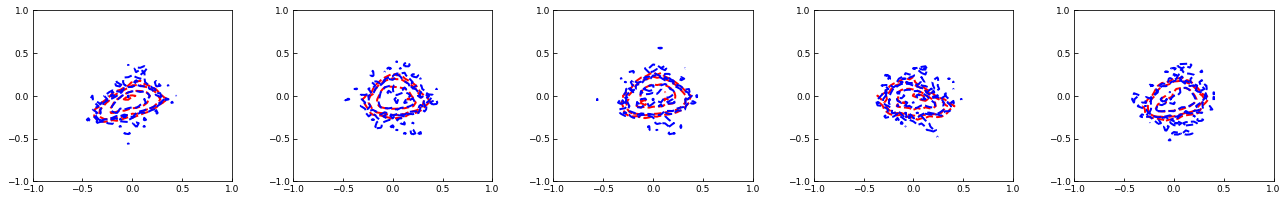

In [32]:
Beams_zk=Model.FF(T.cat((T.zeros((2,3)),T.tensor(fit_zk[0:-5*11]).reshape(2,-1)),axis=1),
                  T.tensor(fit_zk[-5*11:-5*5]),
                  T.tensor(fit_zk[-5*5:])).numpy()
Beams_ref=Model.FF(T.zeros((2,poly_N(z_order))),
                  T.tensor([1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0,
                            1,0,0,0,0,0]),
                  T.zeros(5*5)).numpy()
# Blue contour lines represent reference beams.
# Red is the fitted beams for the measured beams. 
x0=np.linspace(-1,1,51)
y0=np.linspace(-1,1,51)
plot_beamcontour(x0,y0,Beams_zk,Meas_beam,
                 levels=[-35,-30,-20,-15])